# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры, влияющие на цену. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Первый взгляд на данные. 

In [1]:
import pandas as pd
import seaborn as sns
import phik
import matplotlib.pyplot as plt

from IPython.display import display 

pd.set_option('future.no_silent_downcasting', True)

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t') 
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

К сожалению, в данных присутствуют пропуски, в дальнейшем посмотрим их подробнее. 

array([[<Axes: title={'center': 'total_images'}>,
        <Axes: title={'center': 'last_price'}>,
        <Axes: title={'center': 'total_area'}>,
        <Axes: title={'center': 'rooms'}>],
       [<Axes: title={'center': 'ceiling_height'}>,
        <Axes: title={'center': 'floors_total'}>,
        <Axes: title={'center': 'living_area'}>,
        <Axes: title={'center': 'floor'}>],
       [<Axes: title={'center': 'kitchen_area'}>,
        <Axes: title={'center': 'balcony'}>,
        <Axes: title={'center': 'airports_nearest'}>,
        <Axes: title={'center': 'cityCenters_nearest'}>],
       [<Axes: title={'center': 'parks_around3000'}>,
        <Axes: title={'center': 'parks_nearest'}>,
        <Axes: title={'center': 'ponds_around3000'}>,
        <Axes: title={'center': 'ponds_nearest'}>],
       [<Axes: title={'center': 'days_exposition'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

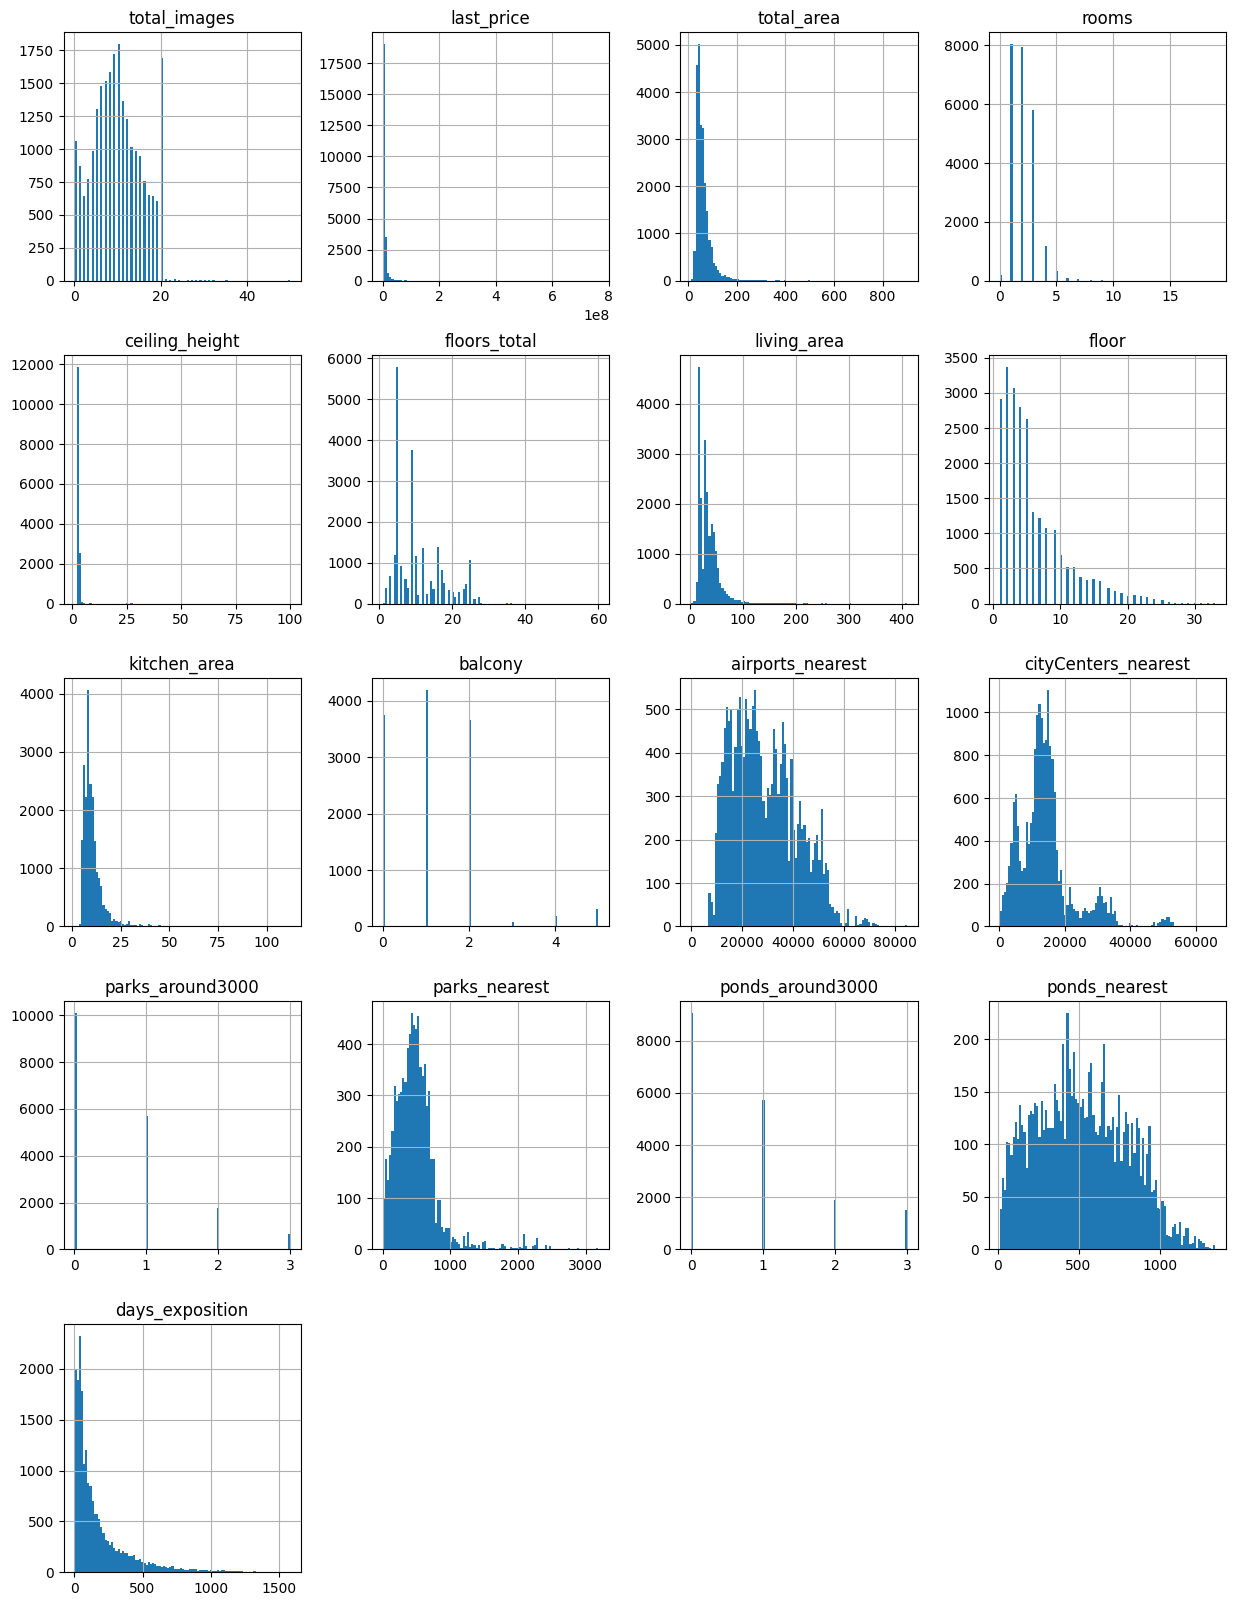

In [4]:
data.hist(figsize=(15, 20), bins=100)

В принципе, на первый взгляд ничего сверх необычного, кроме некоторых странностей по типу отстутсвующих предложений с нулем прудов поблизости на 'ponds_around3000', позже посмотрим каждый параметр отдельно.

## Предобработка данных

### Проверка наличия дубликатов и пропущенных значений

Посмотрим явные дубликаты.

In [5]:
data.duplicated().sum()

0

Их нет, хорошо, перейдем к пропускам.

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Примерно так выглядит количество пропусков, посмотрим, что можно сделать. 

### Простые решения по заполнению пропущенных значений

Для начала обратимся к данным, проблемы в которых решаются относительно просто. 

In [7]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Данный столбец отвечает на вопрос, является ли помещение апартаментами, и по сути своей может принять только два значения: "да" или 'нет', является булевым иными словами. Вероятно, пропущены значения "нет", которые мы и добавили. Кроме того, тип данных сменили на int, так как потом из-за булевого значения возникли проблемы с графиками. Возможно это несколько нерационально с точки зрения использования памяти, но размер таблицы не слишком большой. 

In [8]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)
data = data.astype({'is_apartment':'int64'})
data['is_apartment'].unique()

array([0, 1], dtype=int64)

Аналогично поменяли тип данных на, имхо, более удобный в данной ситуации. 

In [9]:
data = data.astype({'studio':'int64'}) 
data = data.astype({'open_plan':'int64'}) 

Посмотрим балконы.

In [10]:
data['balcony'].unique() 

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Ситуация похожа на предыдущую, вероятно, не указано, когда балконов нет совсем. Дробные балконы же вряд ли существуют, поэтому меняем тип на int.

In [11]:
data['balcony'] = data['balcony'].fillna(value=0) 
data = data.astype({'balcony':'int64'})
data['balcony'].unique() 

array([0, 2, 1, 5, 4, 3], dtype=int64)

Перейдем к прудам и паркам.

In [12]:
data['parks_around3000'].unique() 

array([ 1.,  0.,  2., nan,  3.])

Скорее всего пропущено значение "0", если данные вещи были заполнены вручную, то люди их отсутствие могли просто не указать, как и в предыдущих случаях.

In [13]:
data['parks_around3000'] = data['parks_around3000'].fillna(0) 
data = data.astype({'parks_around3000':'int64'}) 

In [14]:
data['ponds_around3000'].unique() 

array([ 2.,  0.,  3.,  1., nan])

In [15]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data = data.astype({'ponds_around3000':'int64'})

Для последующего удобства преобразуем формат данных в столбце 'first_day_exposition'.

In [16]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') 
data['first_day_exposition'].head(5)

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

### Заполнение медианами

Посмотрим высоту потолков.

In [17]:
display(data['ceiling_height'].median())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) 
data['ceiling_height'].unique()

2.65

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,   2.45,
         3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,
         2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,
         4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,
      

Все замечательно, но стометровые потолки - это как-то слишком много, а метровые наоборот, слишком малы. Правдоподобной выглядит планка от 2 до 10. Пробелы в данном случае могут быть вызваны тем, что высоту потолков просто не указали в объявлении, и их можно спокойно заполнить медианой.

In [18]:
data = data.query('2 < ceiling_height < 10')
data['ceiling_height'].unique()

array([2.7 , 2.65, 3.03, 2.5 , 2.67, 2.56, 3.05, 2.75, 2.6 , 2.9 , 2.8 ,
       2.55, 3.  , 3.2 , 2.61, 3.25, 3.45, 2.77, 2.85, 2.64, 2.57, 4.15,
       3.5 , 3.3 , 2.71, 4.  , 2.47, 2.73, 2.84, 3.1 , 2.34, 3.4 , 3.06,
       2.72, 2.54, 2.51, 2.78, 2.76, 2.58, 3.7 , 2.52, 5.2 , 2.87, 2.66,
       2.59, 2.45, 3.6 , 2.92, 3.11, 3.13, 3.8 , 3.15, 3.55, 3.16, 3.62,
       3.12, 2.53, 2.74, 2.96, 2.46, 5.3 , 5.  , 2.79, 2.95, 4.06, 2.94,
       3.82, 3.54, 3.53, 2.83, 4.7 , 2.4 , 3.38, 3.01, 5.6 , 3.65, 3.9 ,
       3.18, 3.35, 2.3 , 3.57, 2.48, 2.62, 2.82, 3.98, 2.63, 3.83, 3.52,
       3.95, 3.75, 2.88, 3.67, 3.87, 3.66, 3.85, 3.86, 4.19, 3.24, 4.8 ,
       4.5 , 4.2 , 3.36, 3.08, 3.68, 3.07, 3.37, 3.09, 8.  , 3.26, 3.34,
       2.81, 3.44, 2.97, 3.14, 4.37, 2.68, 3.22, 3.27, 4.1 , 2.93, 3.46,
       3.47, 3.33, 3.63, 3.32, 8.3 , 2.98, 2.86, 3.17, 4.4 , 3.28, 3.04,
       4.45, 5.5 , 3.84, 3.23, 3.02, 3.21, 3.43, 3.78, 4.3 , 3.39, 2.69,
       3.31, 4.65, 3.56, 2.2 , 3.51, 3.93, 3.42, 2.

Отлично, перейдем к количеству этажей.

In [19]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., 20., 28.,
       36., 21., 35., 34., 60.,  1., 29., 33., 52.])

Аналогично предыдущему, количество этажей можно заполнить медианой, вот только нет в СПБ и области домов в 52 этажа, Лахта-центр еще строится, есть Лидер Тауэр в 42 этажа, все, что больше, уберем. Заодно сменим тип на int, дробных этажей не бывает.

In [20]:
data = data.query('floors_total <= 42')
data = data.astype({'floors_total':'int64'})
data['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34,  1, 29, 33],
      dtype=int64)

Посмотрим на 'days_expositon'.

In [21]:
data['days_exposition'].unique()

array([  nan,   81.,  558., ..., 1360., 1007.,  971.])

Проанализируем пропуски по годам, есть подозрение на закономерность.

In [22]:
data['year_of_publ'] = data['first_day_exposition'].dt.year 

years = []
list_of_nan_values= [] 
list_of_total_values = []

for year, group_data in data.groupby('year_of_publ'):
    list_of_nan_values.append(group_data['days_exposition'].isna().sum())
    list_of_total_values.append((group_data['days_exposition'].isna().count()))
    years.append(year) 
    

data_for_df = {'nan_values': list_of_nan_values, 'total_values': list_of_total_values}
df = pd.DataFrame(data = data_for_df, index=years) 
df = df.sort_values(by='nan_values', ascending=False) 
df['ratio'] = df['nan_values'] / df['total_values'] 
df

,nan_values,total_values,ratio
2019,1791,2871,0.623824
2018,956,8501,0.112457
2017,270,8176,0.033023
2015,70,1190,0.058824
2016,67,2783,0.024075
2014,18,137,0.131387


Да, действительно, закономерность есть, процент пропусков в 2019 году очень большой- 62%. Вообще столбец в "days_exposition" содержит информацию о том, за сколько дней была продана квартира. Соответственно, если объявление было сделано в 2019 году, то пробелы в столбце "days_exposition" говорят о том, что часть квартир в принципе еще не была продана на момент выгрузки данных. Аналогичное можно подумать и про пробелы за другие года. Наверно, этот столбец правильно было бы вообще не трогать, однако медиана в этом плане не так плоха, большая часть квартир так или иначе будет продана аналогично другим.

In [23]:
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())
data = data.astype({'days_exposition':'int64'})

### Менее тривиальные решения

Перейдем к пробелам в 'living_area'. Жилую площадь и площадь кухни заполним медианным соотношением между жилой и общей площадью, площадью кухни и общей площадью по данным, которые у нас есть.

In [24]:
living_area_ratio = (data['living_area'] / data['total_area']).median() 
data['living_area'] = data['living_area'].fillna(data['total_area'] * living_area_ratio) 

In [25]:
kitchen_area_ratio = (data['kitchen_area'] / data['total_area']).median() 
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * kitchen_area_ratio)

Посмотрим на столбец с названиями населенных пунктов. Возможно, там есть неявные дубликаты.

In [26]:
locality = data['locality_name'].astype({'locality_name':'str'}) 
sorted(locality.unique()) 

['nan',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 

Да, у нас оказалось два варианта поселка.

In [27]:
data['locality_name'] = data['locality_name'].str.replace("посёлок", "поселок")

Посмотрим на столбец с названиями населенных пунктов, заменим посёлок на поселок для единообразия. К слову, пропусков в названиях населенных пунктов немного - 49, можно было бы их просто удалить, но они не мешают, и мы решили их оставить, чтобы не терять значения. 

По поводу значений ближайших аэропортов, ситицентров, прудов или парков, здесь пропуски можно поделить на два типа:

- Вызванные отсутствием того или иного объекта инфраструктуры в населенном пункте, в частности, было бы странно ожидать в каждой деревне аэродром. 
- "Потерянные значения", когда объект есть, но расстояние до него не указано. 

Поэтому данные конструкции ищут, если ли в населенном пункте указанные значения, помимо пропущенных, и заполняют их медианами по населенному пункту.

In [28]:
nan_list = []
for name, group_data in data.groupby('locality_name'):
    nan_list = pd.isna(group_data['airports_nearest'].unique()) 
    if False in nan_list and True in nan_list: 
        data.loc[(data['locality_name'] == name) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == name), 'airports_nearest'].median()

In [29]:
nan_list = []
for name, group_data in data.groupby('locality_name'):
    nan_list = pd.isna(group_data['cityCenters_nearest'].unique()) 
    if False in nan_list and True in nan_list: 
        data.loc[(data['locality_name'] == name) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['locality_name'] == name), 'cityCenters_nearest'].median() 

In [30]:
nan_list = []
for name, group_data in data.groupby('locality_name'):
    nan_list = pd.isna(group_data['parks_nearest'].unique()) 
    if False in nan_list and True in nan_list:
        data.loc[(data['locality_name'] == name) & (data['parks_nearest'].isna()), 'parks_nearest'] = \
    data.loc[(data['locality_name'] == name), 'parks_nearest'].median()

In [31]:
nan_list = []
for name, group_data in data.groupby('locality_name'):
    nan_list = pd.isna(group_data['ponds_nearest'].unique()) 
    if False in nan_list and True in nan_list:
        data.loc[(data['locality_name'] == name) & (data['ponds_nearest'].isna()), 'ponds_nearest'] = \
    data.loc[(data['locality_name'] == name), 'ponds_nearest'].median()

### Выводы по предобработке

In [32]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name             49
airports_nearest        4856
cityCenters_nearest     4856
parks_around3000           0
parks_nearest           6013
ponds_around3000           0
ponds_nearest           4979
days_exposition            0
year_of_publ               0
dtype: int64

Получилось убрать некоторую часть пропусков, однако некоторые из них обусловлены отсутствием объекта, до которого измеряется расстояние, либо пропущенным названием населенного пункта, такие пропуски заполнить нечем.

## Добавление новых столбцов

In [33]:
#считаем цену за квадрат
data['price_per_sq_meter'] = data['last_price'] / data['total_area'] 

#выделяем из даты день недели 
data['day_of_publ'] = data['first_day_exposition'].dt.weekday 

#ведылеяем из даты месяц
data['month_of_publ'] = data['first_day_exposition'].dt.month 

#выделяем из даты год
data['year_of_publ'] = data['first_day_exposition'].dt.year

In [34]:
#финкция должна получать значения двех столбцов и определять тип этажа
def floortype(floor, floors_total):
    if floor == 1:
        return "первый" 
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой' 


In [35]:
data['floortype'] = data.apply(lambda x: floortype(x.floor, x.floors_total), axis=1) 
data['floortype'].head(5)

0    другой
1    первый
2    другой
3    другой
4    другой
Name: floortype, dtype: object

In [36]:
#переводим некоторые расстояния в километры
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] // 1000 
data = data.astype({'cityCenters_nearest_km':'Int64'}) 
data['airports_nearest_km'] = data['airports_nearest'] / 1000 
data['parks_nearest_km'] = data['parks_nearest'] / 1000
data['cityCenters_nearest_km'].head(5)

0    16
1    18
2    13
3     6
4     8
Name: cityCenters_nearest_km, dtype: Int64

In [37]:
#переводим цену в миллионы
data['last_price_in_millions'] = data['last_price'] / 1000000 

Таким образом, мы добавили некоторые значения в таблицу, а привели другие в более удобный вид. Теперь уберем лишние столбцы.

In [38]:
data.drop(['cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'last_price'], axis=1, inplace=True)

## Исследовательский анализ данных

### Анализ общей площади

In [39]:
data['total_area'].describe()

count    23658.000000
mean        60.365933
std         35.674567
min         12.000000
25%         40.000000
50%         52.000000
75%         69.975000
max        900.000000
Name: total_area, dtype: float64

Итак, общая площадь имеет довольно неоднородную структуру( ско - 35 при среднем 60), что может говорить о большем количестве выбросов, посмотрим на боксплот.

<Axes: title={'center': 'Total area, m^2'}>

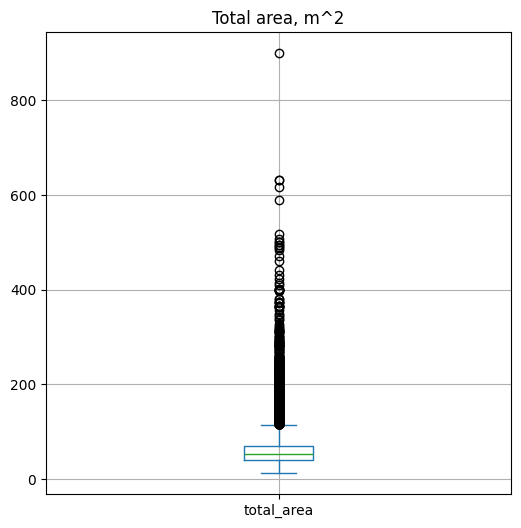

In [40]:
data['total_area'].plot(kind='box', figsize=(6, 6), grid=True, title='Total area, m^2')

Да, выбросов очень много, как можно заметить большая часть данных расположена примерно до 80 квадратных метров, а вот максимальные значения есть и больше 800. Их нужно убрать, вопрос в том, насколько агрессивно обрезать этот "хвост", я предпочту убрать все, что больше 150, при этом нужно проверять, сколько данных мы потеряли на таких вещах, поэтому преобразования буду делать в отдельной переменной.

In [41]:
new_data = data.query('total_area < 150') 
len(new_data.index) / len(data.index) 

0.9753994420492011

Потеряли 2.5%, нормально.

<Axes: title={'center': 'Total area, m^2'}, ylabel='Frequency'>

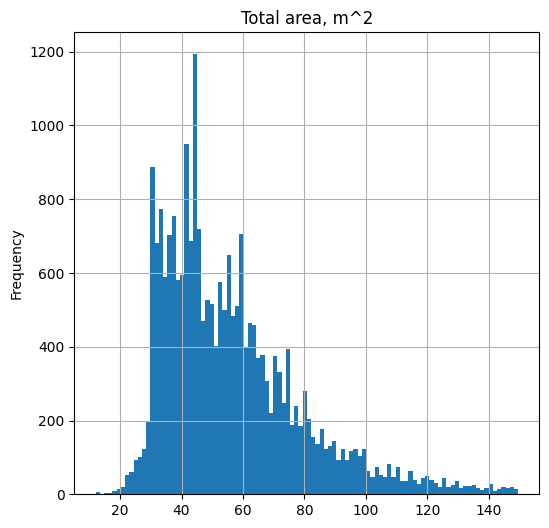

In [42]:
new_data['total_area'].plot(kind='hist', bins=100, title='Total area, m^2', grid=True, figsize=(6, 6)) 

Теперь можно построить гистограмму, как видно, большая часть "хвоста" ушла, есть ярко выраженный пик чуть больше 40 метров. В целом все нормально идем дальше.

### Анализ жилой площади

In [43]:
data['living_area'].describe()

count    23658.000000
mean        34.586174
std         22.351072
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

Разброс, опять же, очень большой. Идем смотреть боксплот.

<Axes: title={'center': 'Living area, m^2'}>

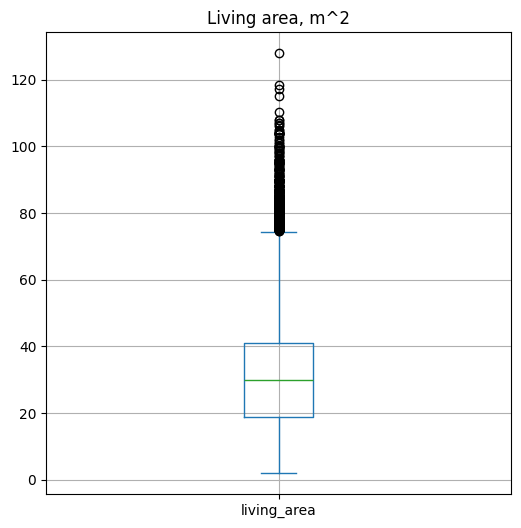

In [44]:
new_data['living_area'].plot(kind='box', figsize=(6,6), grid=True, title ='Living area, m^2')

Здесь выбросов все-таки меньше, чем на предыдущем этапе, вероятно, мы срезали большую их часть там. Здесь же уберем все, что больше 100 м^2, наверно, можно было бы и агрессивнее. 

0.9740468340519063

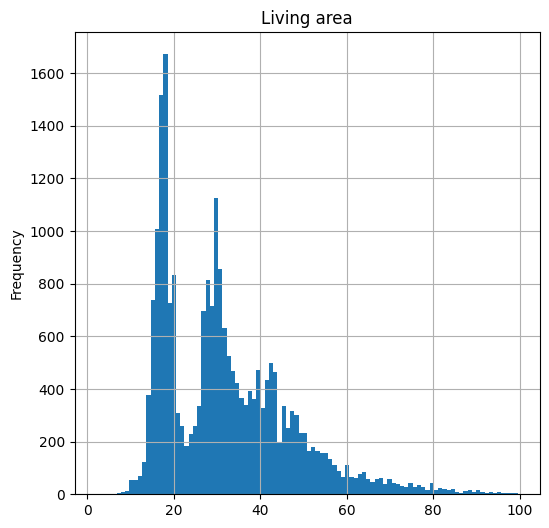

In [45]:
new_data = new_data.query('living_area < 100') 
new_data['living_area'].plot(kind='hist', bins=100, title='Living area', grid=True, figsize=(6, 6)) 
len(new_data.index) / len(data.index) 

Некоторый хвост остался, кроме того бросается в глаза разрыв в районе 23 квадратных метров жилой площади. Вероятно, это какая-то не слишком удачная планировка квартир, но выглядит странно.

### Анализ площади кухни

In [46]:
data['kitchen_area'].describe()

count    23658.000000
mean        10.494459
std          6.032821
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<Axes: >

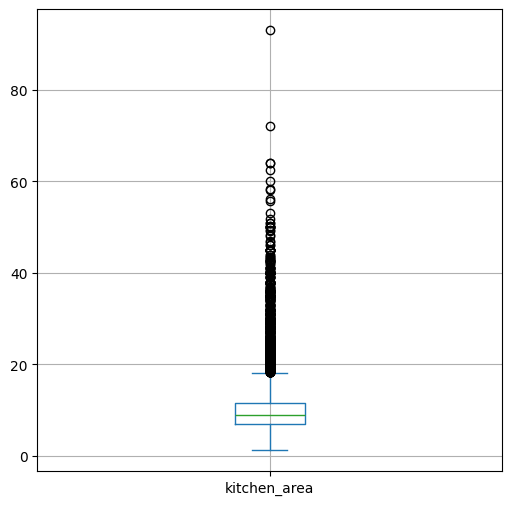

In [47]:
new_data['kitchen_area'].plot(kind='box', figsize=(6,6), grid=True)

Снова, срезать хвост можно по-разному, я остановлюсь на цифре 40

0.9707498520585003

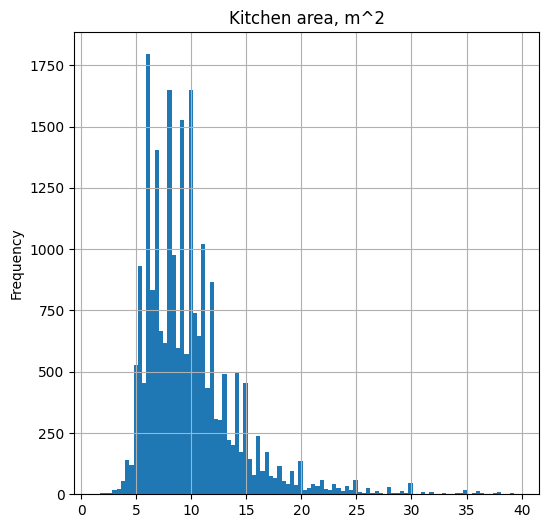

In [48]:
new_data = new_data.query('kitchen_area < 40') 
new_data['kitchen_area'].plot(kind='hist', bins=100, title='Kitchen area, m^2', grid=True, figsize=(6, 6))
len(new_data.index) / len(data.index) 

Некоторый хвост остался, но не критично. Общие потери - 3% данных, пик площади кухни примерно 6 метра квадратных, но есть близкие по популярности значения.

### Анализ цены

In [49]:
new_data['last_price_in_millions'].describe()

count    22966.000000
mean         5.618425
std          4.287715
min          0.430000
25%          3.400000
50%          4.550000
75%          6.500000
max        124.000000
Name: last_price_in_millions, dtype: float64

И снова выбросы, смотрим боксплот.

<Axes: >

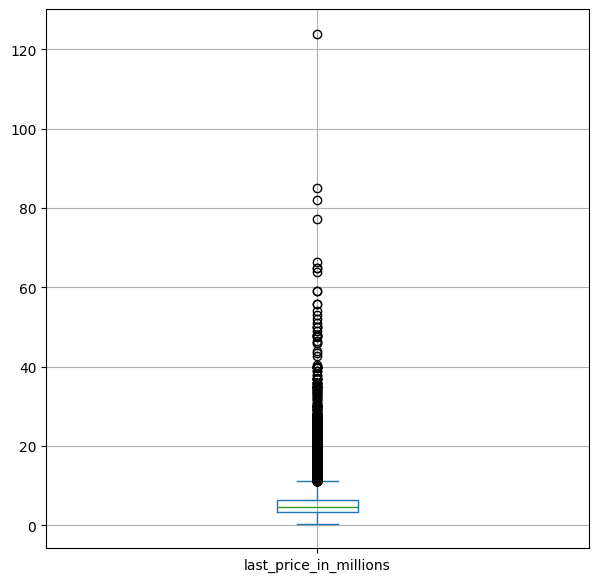

In [50]:
new_data['last_price_in_millions'].plot(kind='box', figsize=(7,7), grid=True) 

Я предпочту убрать все, что больше 15 миллионов - это несколько более решительно, но цена очень нужна нам в дальнейшем анализе.

0.9420069321159862

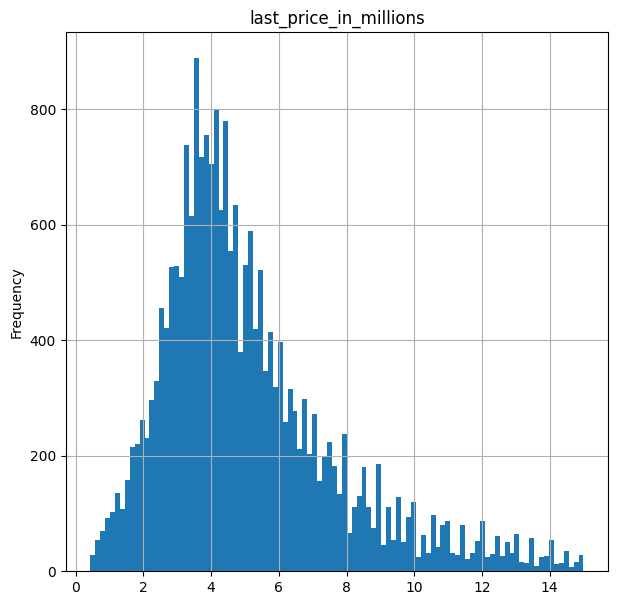

In [51]:
new_data = new_data.query('last_price_in_millions < 15')
new_data['last_price_in_millions'].plot(kind='hist', bins=100, title='last_price_in_millions', grid=True, figsize=(7, 7))
len(new_data.index) / len(data.index)

Самый близкий к "табличному" нормальному распределению график из всех, отлично. Уровень потерь - 5.8%, все еще нормально.

### Анализ количества комнат

In [52]:
new_data['rooms'].describe()

count    22286.000000
mean         1.962577
std          0.927451
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

Квартиры с нулем комнат - это интересно, но непонятно, может речь идет студии и открытые планировки.

In [53]:
rooms_0 = new_data.query('rooms == 0') 
display(rooms_0['studio'].sum()) 
display(rooms_0['open_plan'].sum()) 
rooms_0.count()['rooms']

137

57

194

И правда, тут только студиии и открытые планировки.

<Axes: >

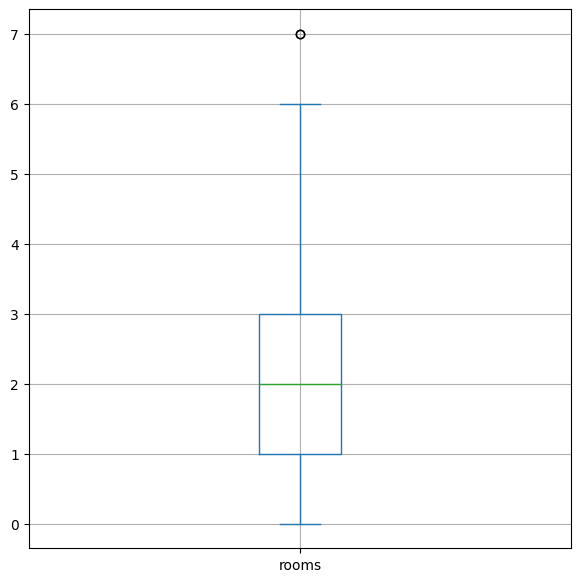

In [54]:
new_data['rooms'].plot(kind='box', figsize=(7,7), grid=True)

Срежем все, что больше шести комнат. 

0.9419223941161552

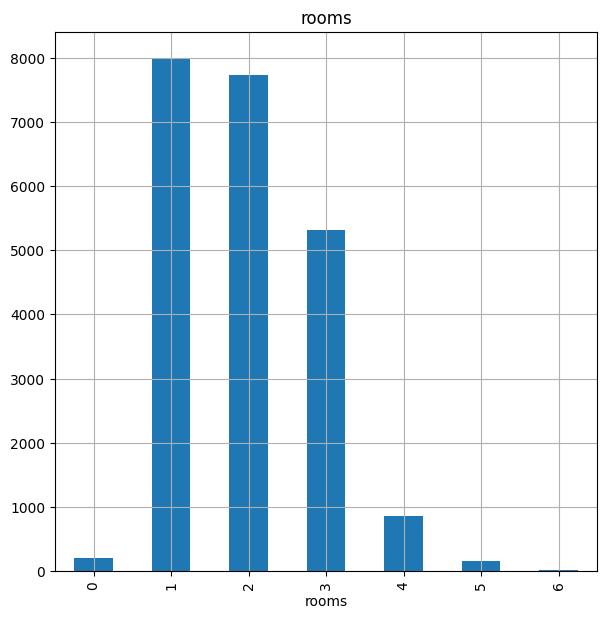

In [55]:
new_data = new_data.query('rooms <= 6') 
new_data.groupby('rooms')['rooms'].count().plot(kind='bar', grid=True, figsize=(7, 7), title='rooms')
len(new_data.index) / len(data.index) 

Все логично, больше всего квартир 1 одной комнатой, меньше всего с шестью. Общие потери - 6.7%.

### Анализ высоты потолков

In [56]:
new_data['ceiling_height'].describe()

count    22284.00000
mean         2.68025
std          0.20353
min          2.20000
25%          2.60000
50%          2.65000
75%          2.70000
max          8.30000
Name: ceiling_height, dtype: float64

Ничего необычного, идем смотреть боксплот.

<Axes: >

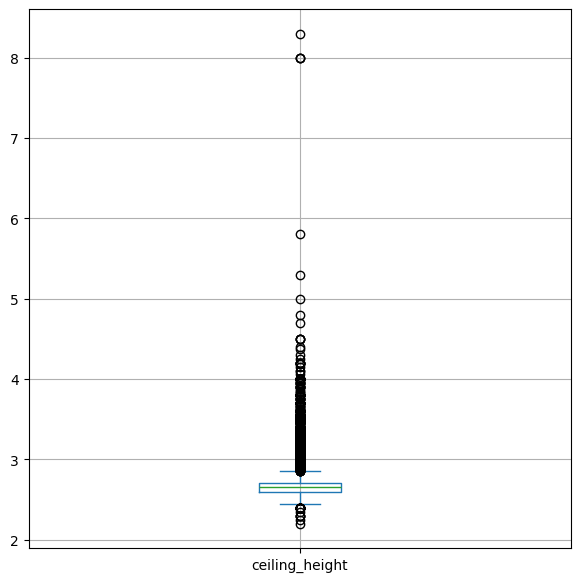

In [57]:
new_data['ceiling_height'].plot(kind='box', figsize=(7,7), grid=True)

Убираем наблюдения, где пололки больше четырех метров, нижний хост трогать не будем.

0.9407388621185223

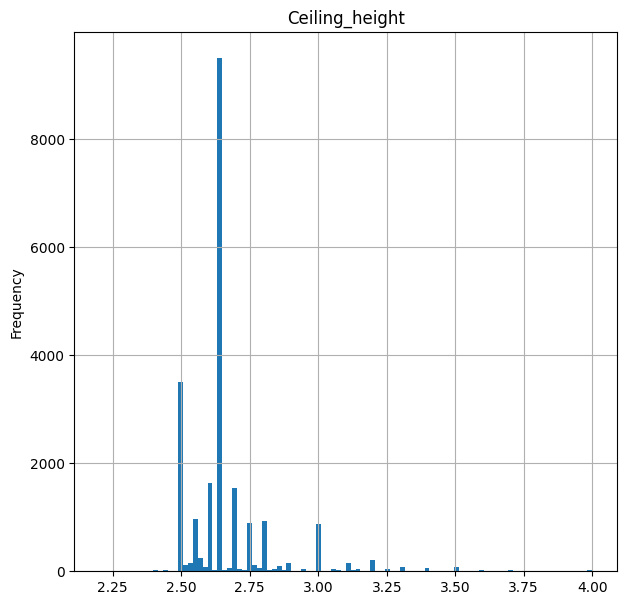

In [58]:
new_data = new_data.query('ceiling_height <= 4') 
new_data['ceiling_height'].plot(kind='hist', bins=100, title='Сeiling_height', grid=True, figsize=(7, 7)) 
len(new_data.index) / len(data.index)

Имеем пик в районе 2.6 метров, частично - это медианные значения, которые мы раньше туда добавили, но он и изначально был, что видно на "ознакомительных" графиках в начале. Впрочем, это не страшно, понятно, что разброс высоты потолков в большинстве домов не может быть большим.

### Анализ этажности

In [59]:
new_data['floor'].describe()

count    22256.000000
mean         5.906228
std          4.914151
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<Axes: title={'center': 'Floor'}>

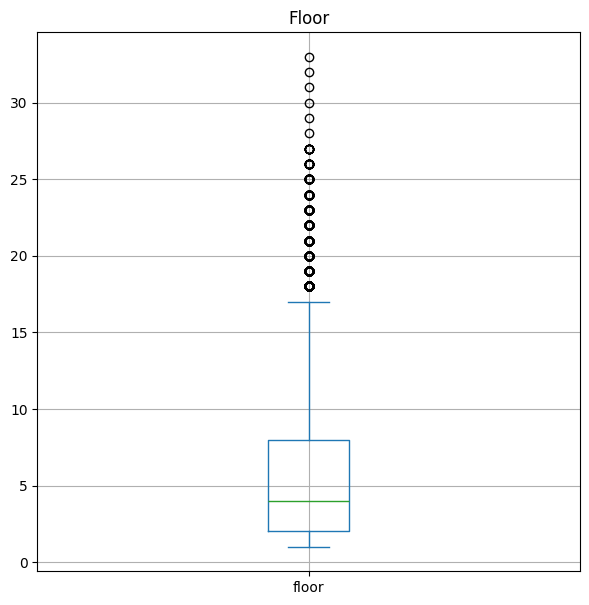

In [60]:
new_data['floor'].plot(kind='box', figsize=(7,7), grid=True, title='Floor') #Посмотрим боксплот

0.9209147011581706

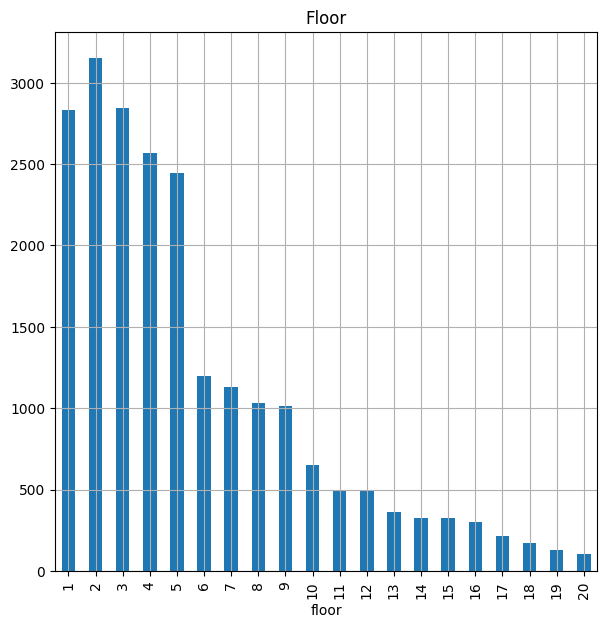

In [61]:
new_data = new_data.query('floor <= 20') #уберем все, что больше 20
new_data.groupby('floor')['floor'].count().plot(kind='bar', grid=True, figsize=(7, 7), title='Floor')
len(new_data.index) / len(data.index)

Больше всего квартир на втором этаже, чем выше этаж, тем меньше квартир, потеря данных - 8.9%, все еще нормально.

<Axes: title={'center': 'Floortype'}, xlabel='floortype'>

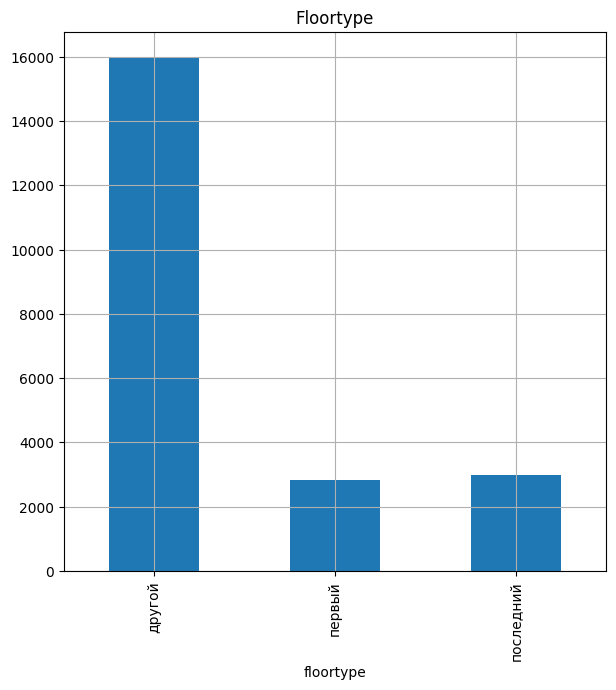

In [62]:
new_data.groupby('floortype')['floortype'].count().plot(kind='bar', grid=True, figsize=(7, 7), title='Floortype')

Большая часть предложенных квартир находится между первой и последней.

<Axes: title={'center': 'Floors total'}>

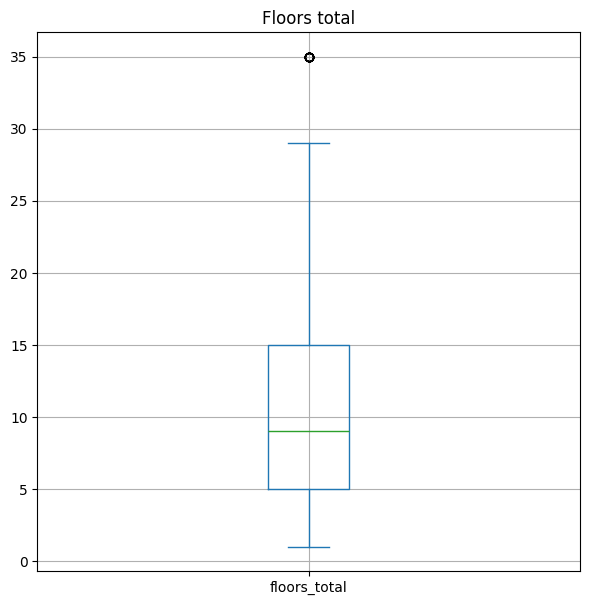

In [63]:
new_data['floors_total'].plot(kind='box', figsize=(7,7), grid=True, title='Floors total')

0.9203229351593541

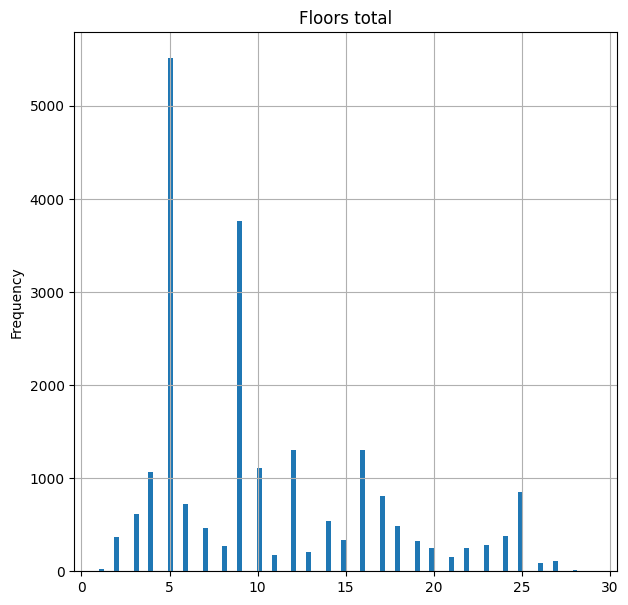

In [64]:
#уберем небольшой выброс в районе 35
new_data = new_data.query('floors_total <= 30') 
new_data['floors_total'].plot(kind='hist', bins=100, title='Floors total', grid=True, figsize=(7, 7)) 
len(new_data.index) / len(data.index)

Больше всего пятиэтажных домов, интересно. Потери данных - 9.8%.

### Анализ расстояния до центра города

In [65]:
new_data['cityCenters_nearest_km'].describe()

count      16965.0
mean     14.439316
std       8.582563
min            0.0
25%           10.0
50%           13.0
75%           16.0
max           65.0
Name: cityCenters_nearest_km, dtype: Float64

<Axes: title={'center': 'CityCenters_nearest, km'}>

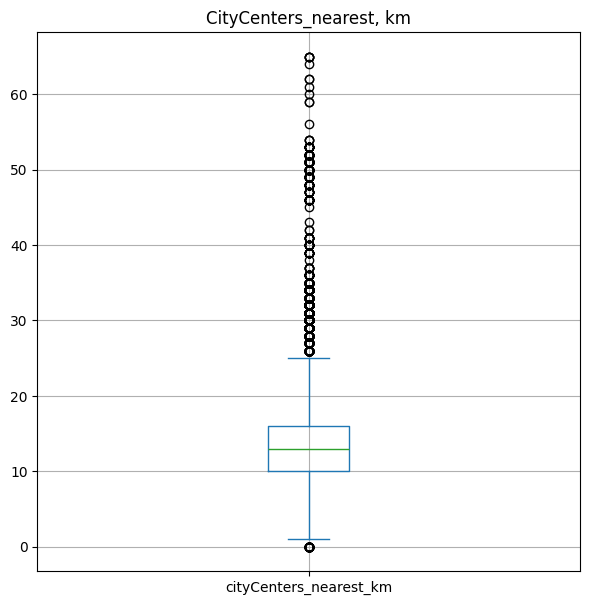

In [66]:
new_data['cityCenters_nearest_km'].plot(kind='box', figsize=(7,7), grid=True, title='CityCenters_nearest, km') #смотрим боксплот

0.9085298841829402

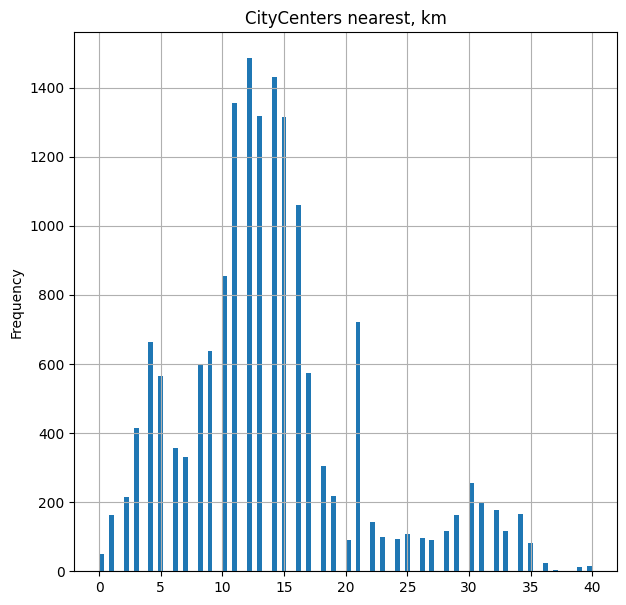

In [67]:
#убираем все, что больше 40 километров, но сохраняем значения с Nan
new_data = new_data.loc[(new_data['cityCenters_nearest_km'] <= 40) | (new_data['cityCenters_nearest_km'].isna())]

new_data['cityCenters_nearest_km'].plot(kind='hist', bins=100, title='CityCenters nearest, km', grid=True, figsize=(7, 7)) 
len(new_data.index) / len(data.index) 

В целом, нормально, есть неожиданный пик на 22 километрах примерно. Потери данных - 10%

### Анализ расстояния до ближайшего аэропорта

In [68]:
new_data['airports_nearest_km'].describe()

count    16686.000000
mean        29.089444
std         12.768092
min          0.000000
25%         18.398250
50%         27.155500
75%         38.092000
max         61.908000
Name: airports_nearest_km, dtype: float64

<Axes: >

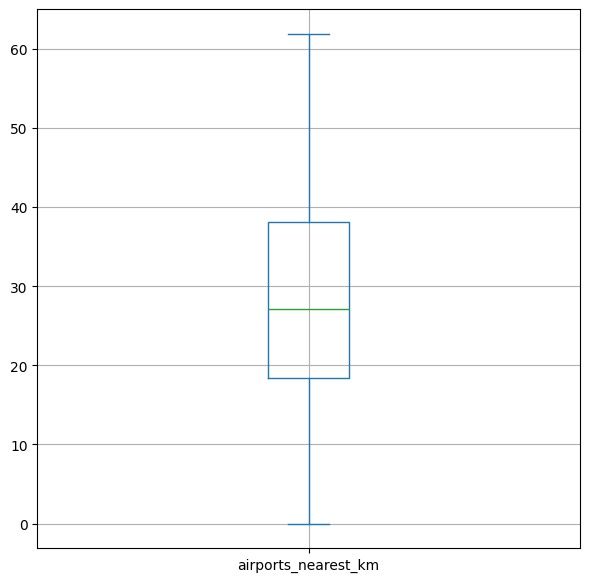

In [69]:
new_data['airports_nearest_km'].plot(kind='box', figsize=(7,7), grid=True)

Тут возникают вопросы по поводу нижней границы, жилых домов в аэропорту быть не может, при этом минимальное расстояние до аэропорта у жилой застройки варируется, уберем все, что ближе десяти километров. 

In [70]:
new_data = new_data.loc[(new_data['airports_nearest_km'] > 10) | (new_data['cityCenters_nearest_km'].isna())] 
len(new_data.index) / len(data.index) 

0.896525488206949

<Axes: title={'center': 'Airports nearest, km'}, ylabel='Frequency'>

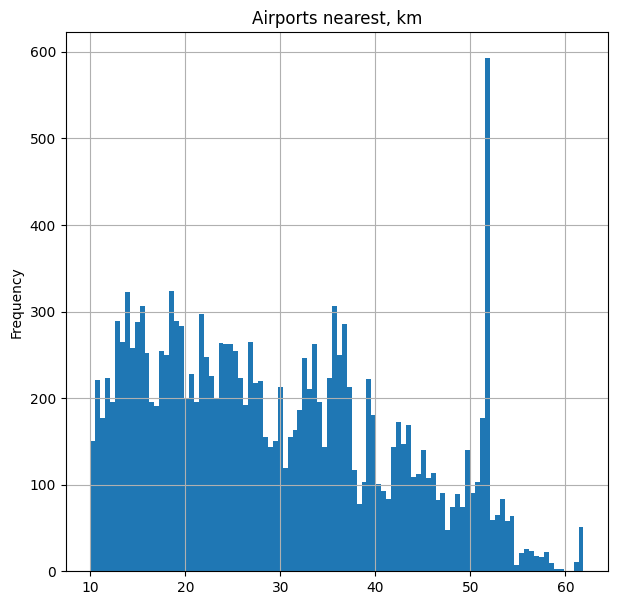

In [71]:
new_data['airports_nearest_km'].plot(kind='hist', bins=100, title='Airports nearest, km', grid=True, figsize=(7, 7))

Вот это распределение, конечно. Ладно, имеем то, что имеем. 

### Анализ расстояния до близжайшего парка

<Axes: title={'center': 'Parks nearest, km'}, ylabel='Frequency'>

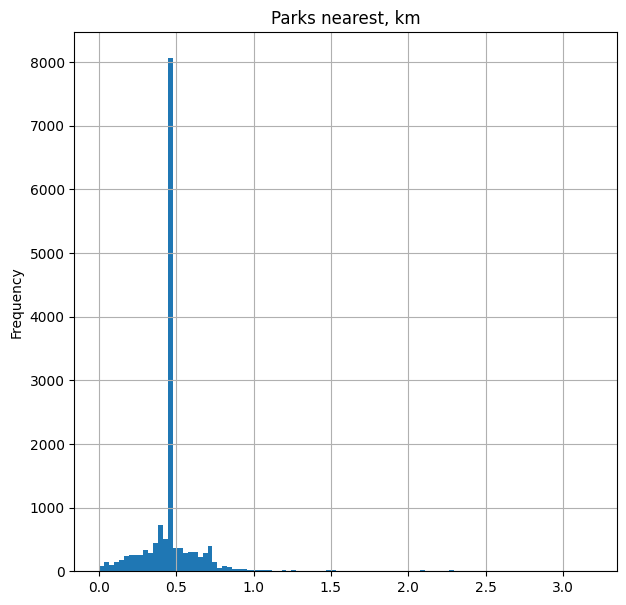

In [72]:
new_data['parks_nearest_km'].plot(kind='hist', bins=100, title='Parks nearest, km', grid=True, figsize=(7, 7))

7720

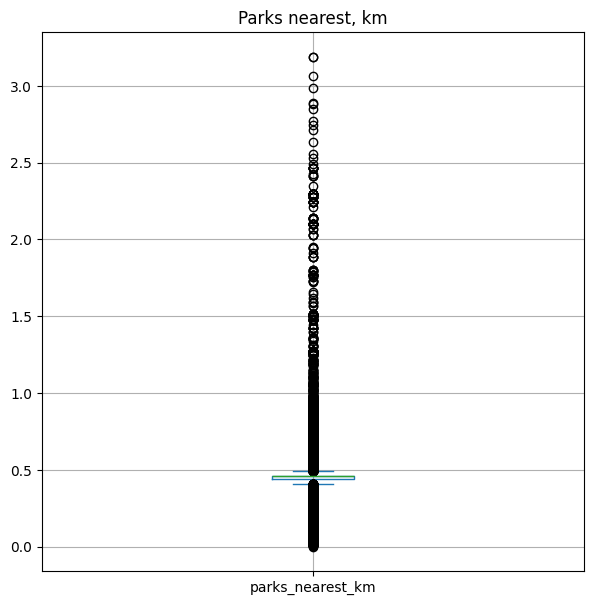

In [73]:
new_data['parks_nearest_km'].plot(kind='box', figsize=(7,7), grid=True, title='Parks nearest, km')
new_data['parks_nearest_km'].mode() 
new_data.loc[new_data['parks_nearest_km'] == 0.46]['parks_nearest_km'].count()

Подозрительный "шпиль", который присутствует в данных с самого начала. Ощущение такое, что большое количество пробелов в данных заполнили одним числом. Не буду с ним ничего делать.

In [74]:
data[data['parks_nearest_km'] == 0.46]['locality_name'].unique()

array(['Санкт-Петербург', 'Пушкин'], dtype=object)

Кроме того, "шпиль" относится к Санкт-Петербургу и Пушкину, судя по карте, в СПБ парков в принципе много, а Пушкин просто небольшой сам по себе. Может быть какая-то ошибка в округлении? Эти данные явно скриптом по карте заполнялись.

### Анализ даты публикации

<Axes: title={'center': 'day_of_puble'}, xlabel='day_of_publ'>

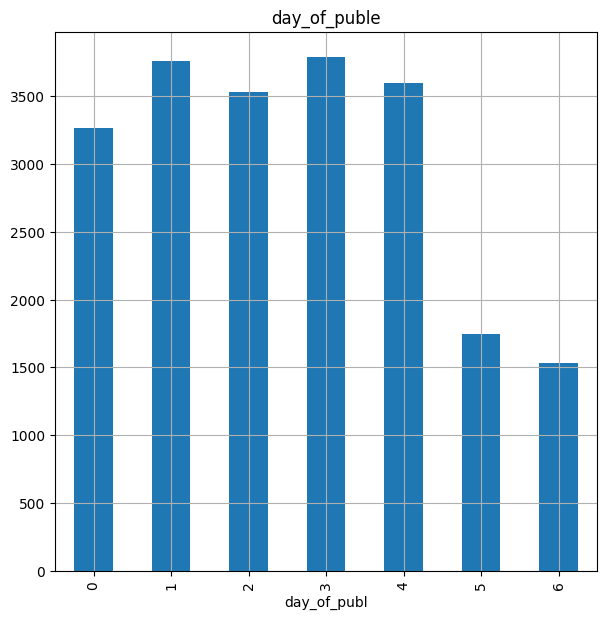

In [75]:
new_data.groupby('day_of_publ')['day_of_publ'].count().plot(kind='bar', grid=True, figsize=(7, 7), title='day_of_puble')

Как можно заметить, большая часть объявлений была выставлена в рабочую часть недели, воскресенье и суббота сильно отстают.

<Axes: title={'center': 'month_of_puble'}, xlabel='month_of_publ'>

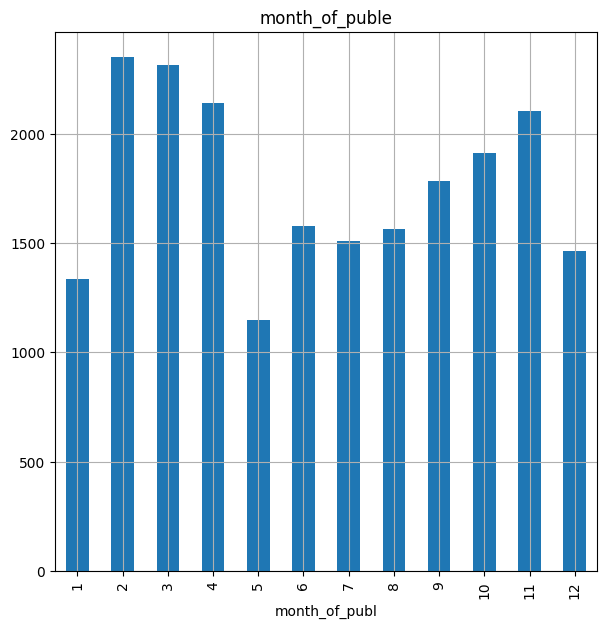

In [76]:
new_data.groupby('month_of_publ')['month_of_publ'].count().plot(kind='bar', grid=True, figsize=(7, 7), title='month_of_puble')

Здесь такой явной динамики нет, кроме разве что того, что явными аутсайдерами оказались май, январь и декабрь, думаю, первые два из-за праздников, а последний из-за подготовки к новому году, когда заниматься квартирами не сильно хочется. 

### Анализ динамики продаж

<Axes: title={'center': 'days exposition'}, ylabel='Frequency'>

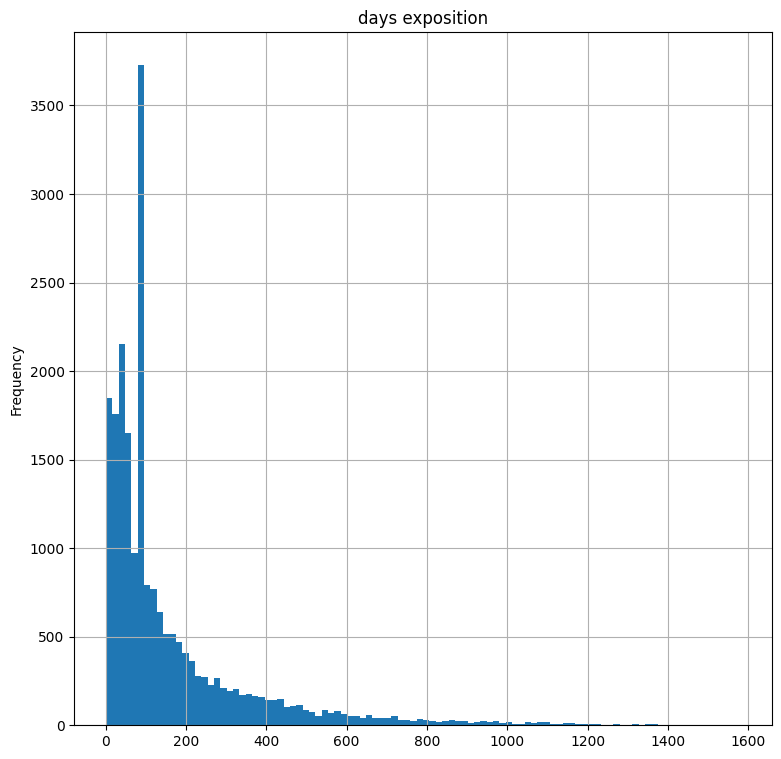

In [77]:
new_data['days_exposition'].plot(kind='hist', bins=100, title='days exposition', grid=True, figsize=(9, 9))

<Axes: title={'center': 'days exposition'}>

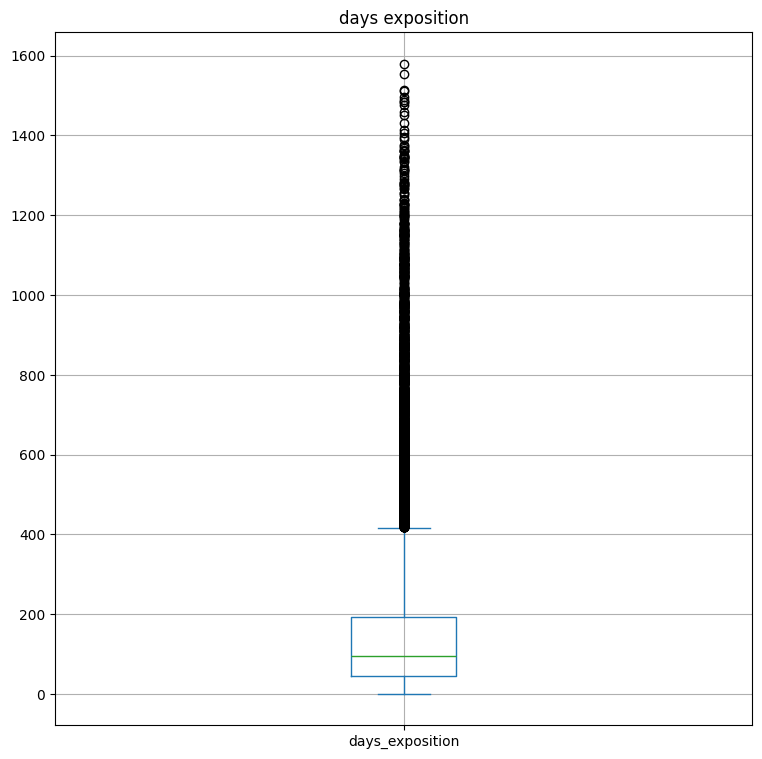

In [78]:
new_data['days_exposition'].plot(kind='box', title='days exposition', grid=True, figsize=(9, 9))

In [79]:
new_data['days_exposition'].describe()

count    21210.000000
mean       165.164922
std        201.647816
min          1.000000
25%         45.000000
50%         95.000000
75%        194.000000
max       1580.000000
Name: days_exposition, dtype: float64

В данном случае среднее сильно отличается от медианы из-за наличия выбросов. Собственно, медиана у нас - 95, а максимальное значение 1580. 
Нормальными в данном случае можно считать продажи от 45 до примерно 400 дней, примерно там заканчивается полтора межквартальных размаха, и дальне начинаются нетипичные значения. Тем не менее, есть неплохой шанс попасть в 75 процентов тех, кто уложился в двести дней и меньше. Продажи до 45 дней, то есть до первого квартиля, я бы назвал быстрыми.  

### Анализ ценообразования

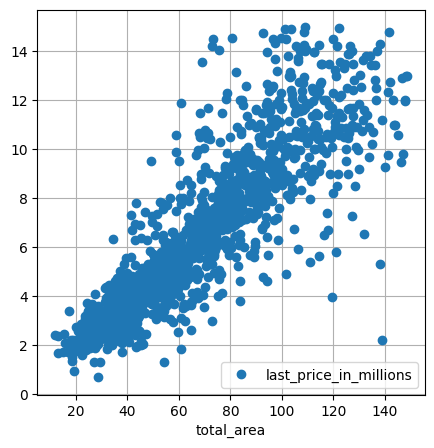

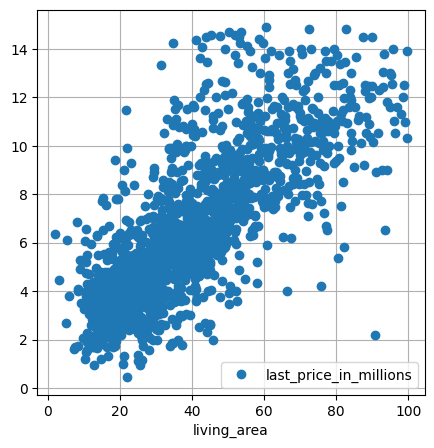

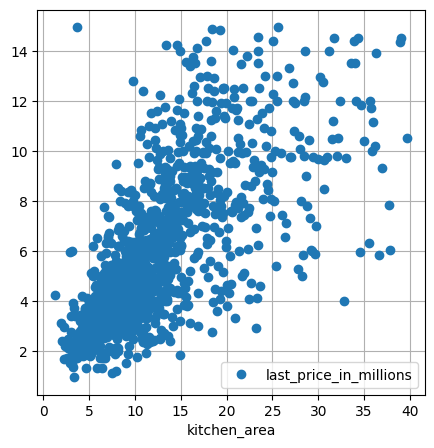

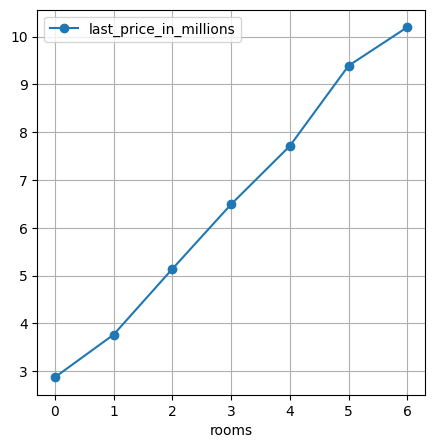

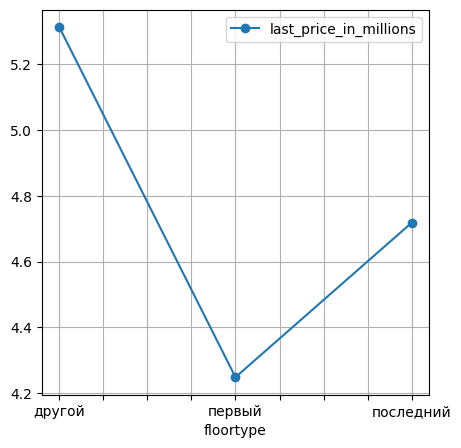

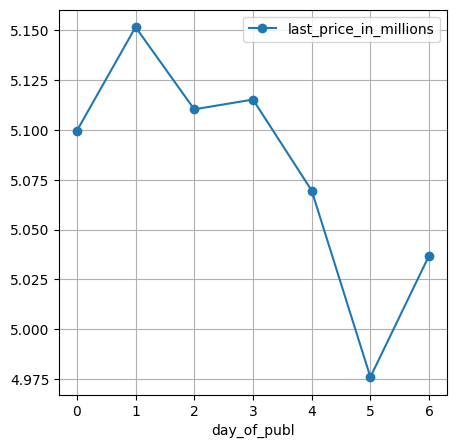

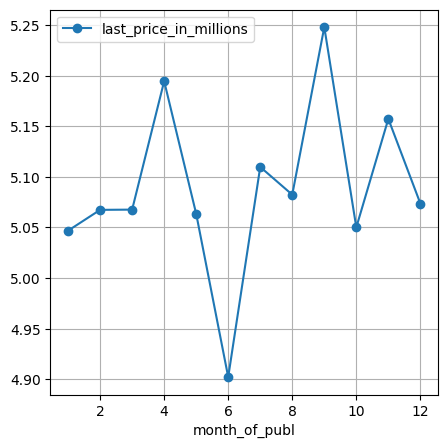

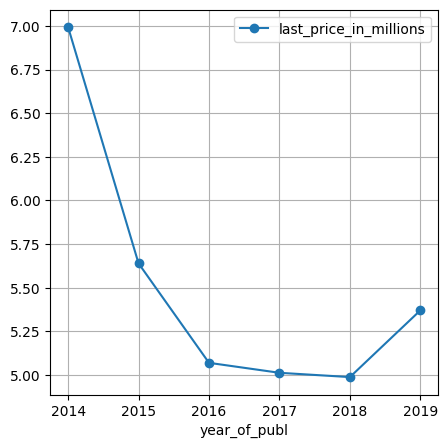

In [80]:
values=['total_area', 'living_area', 'kitchen_area']
for value in values:
    new_data.pivot_table(index=value, values='last_price_in_millions').plot(grid=True, style='o', figsize=(5, 5)) 
    
values = ['rooms', 'floortype', 'day_of_publ', 'month_of_publ', 'year_of_publ']
for value in values:
    new_data.pivot_table(index=value, values='last_price_in_millions').plot(grid=True, style='o-', figsize=(5, 5)) 
    
    

In [81]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21210 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            21210 non-null  int64         
 1   total_area              21210 non-null  float64       
 2   first_day_exposition    21210 non-null  datetime64[ns]
 3   rooms                   21210 non-null  int64         
 4   ceiling_height          21210 non-null  float64       
 5   floors_total            21210 non-null  int64         
 6   living_area             21210 non-null  float64       
 7   floor                   21210 non-null  int64         
 8   is_apartment            21210 non-null  int64         
 9   studio                  21210 non-null  int64         
 10  open_plan               21210 non-null  int64         
 11  kitchen_area            21210 non-null  float64       
 12  balcony                 21210 non-null  int64      

In [82]:
data_types = {'total_images': 'interval',
              'total_area':'interval', 
              'first_day_exposition':'categorical', 
              'rooms':'interval', 
              'ceiling_height':'interval',
              'floors_total':'interval',
              'living_area':'interval',
              'floor':'interval',
              'is_apartment':'categorical', 
              'studio':'categorical', 
              'open_plan':'categorical', 
              'kitchen_area':'interval', 
              'locality_name':'categorical',  
              'parks_around3000':'categorical',
              'ponds_around3000':'categorical',
              'ponds_nearest':'interval', 
              'days_exposition':'interval',
              'month_of_publ':'categorical',
              'floortype':'categorical',
              'cityCenters_nearest_km':'interval',
              'airports_nearest_km':'interval',
              'parks_nearest_km':'interval',
              'last_price_in_millions':'interval',
              'price_per_sq_meter':'interval'
              } 
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in new_data.columns] 
interval_cols 

['total_images',
 'total_area',
 'rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'kitchen_area',
 'ponds_nearest',
 'days_exposition',
 'cityCenters_nearest_km',
 'airports_nearest_km',
 'parks_nearest_km',
 'last_price_in_millions',
 'price_per_sq_meter']

C:\Users\Philka\AppData\Local\Programs\Python\Python312\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable first_day_exposition is large: 1476. Are you sure this is not an interval variable? Analysis for pairs of variables including first_day_exposition can be slow.
  warnings.warn(


last_price_in_millions    1.000000
price_per_sq_meter        0.738833
total_area                0.727303
locality_name             0.695272
living_area               0.640589
kitchen_area              0.549381
cityCenters_nearest_km    0.504167
ceiling_height            0.422316
rooms                     0.407864
floors_total              0.403201
ponds_around3000          0.324693
airports_nearest_km       0.301851
parks_around3000          0.293757
first_day_exposition      0.245212
floortype                 0.227550
floor                     0.224420
ponds_nearest             0.169914
total_images              0.153959
balcony                   0.121920
studio                    0.120602
parks_nearest_km          0.110287
days_exposition           0.099459
year_of_publ              0.089832
open_plan                 0.079921
is_apartment              0.035207
day_of_publ               0.027527
month_of_publ             0.024940
Name: last_price_in_millions, dtype: float64

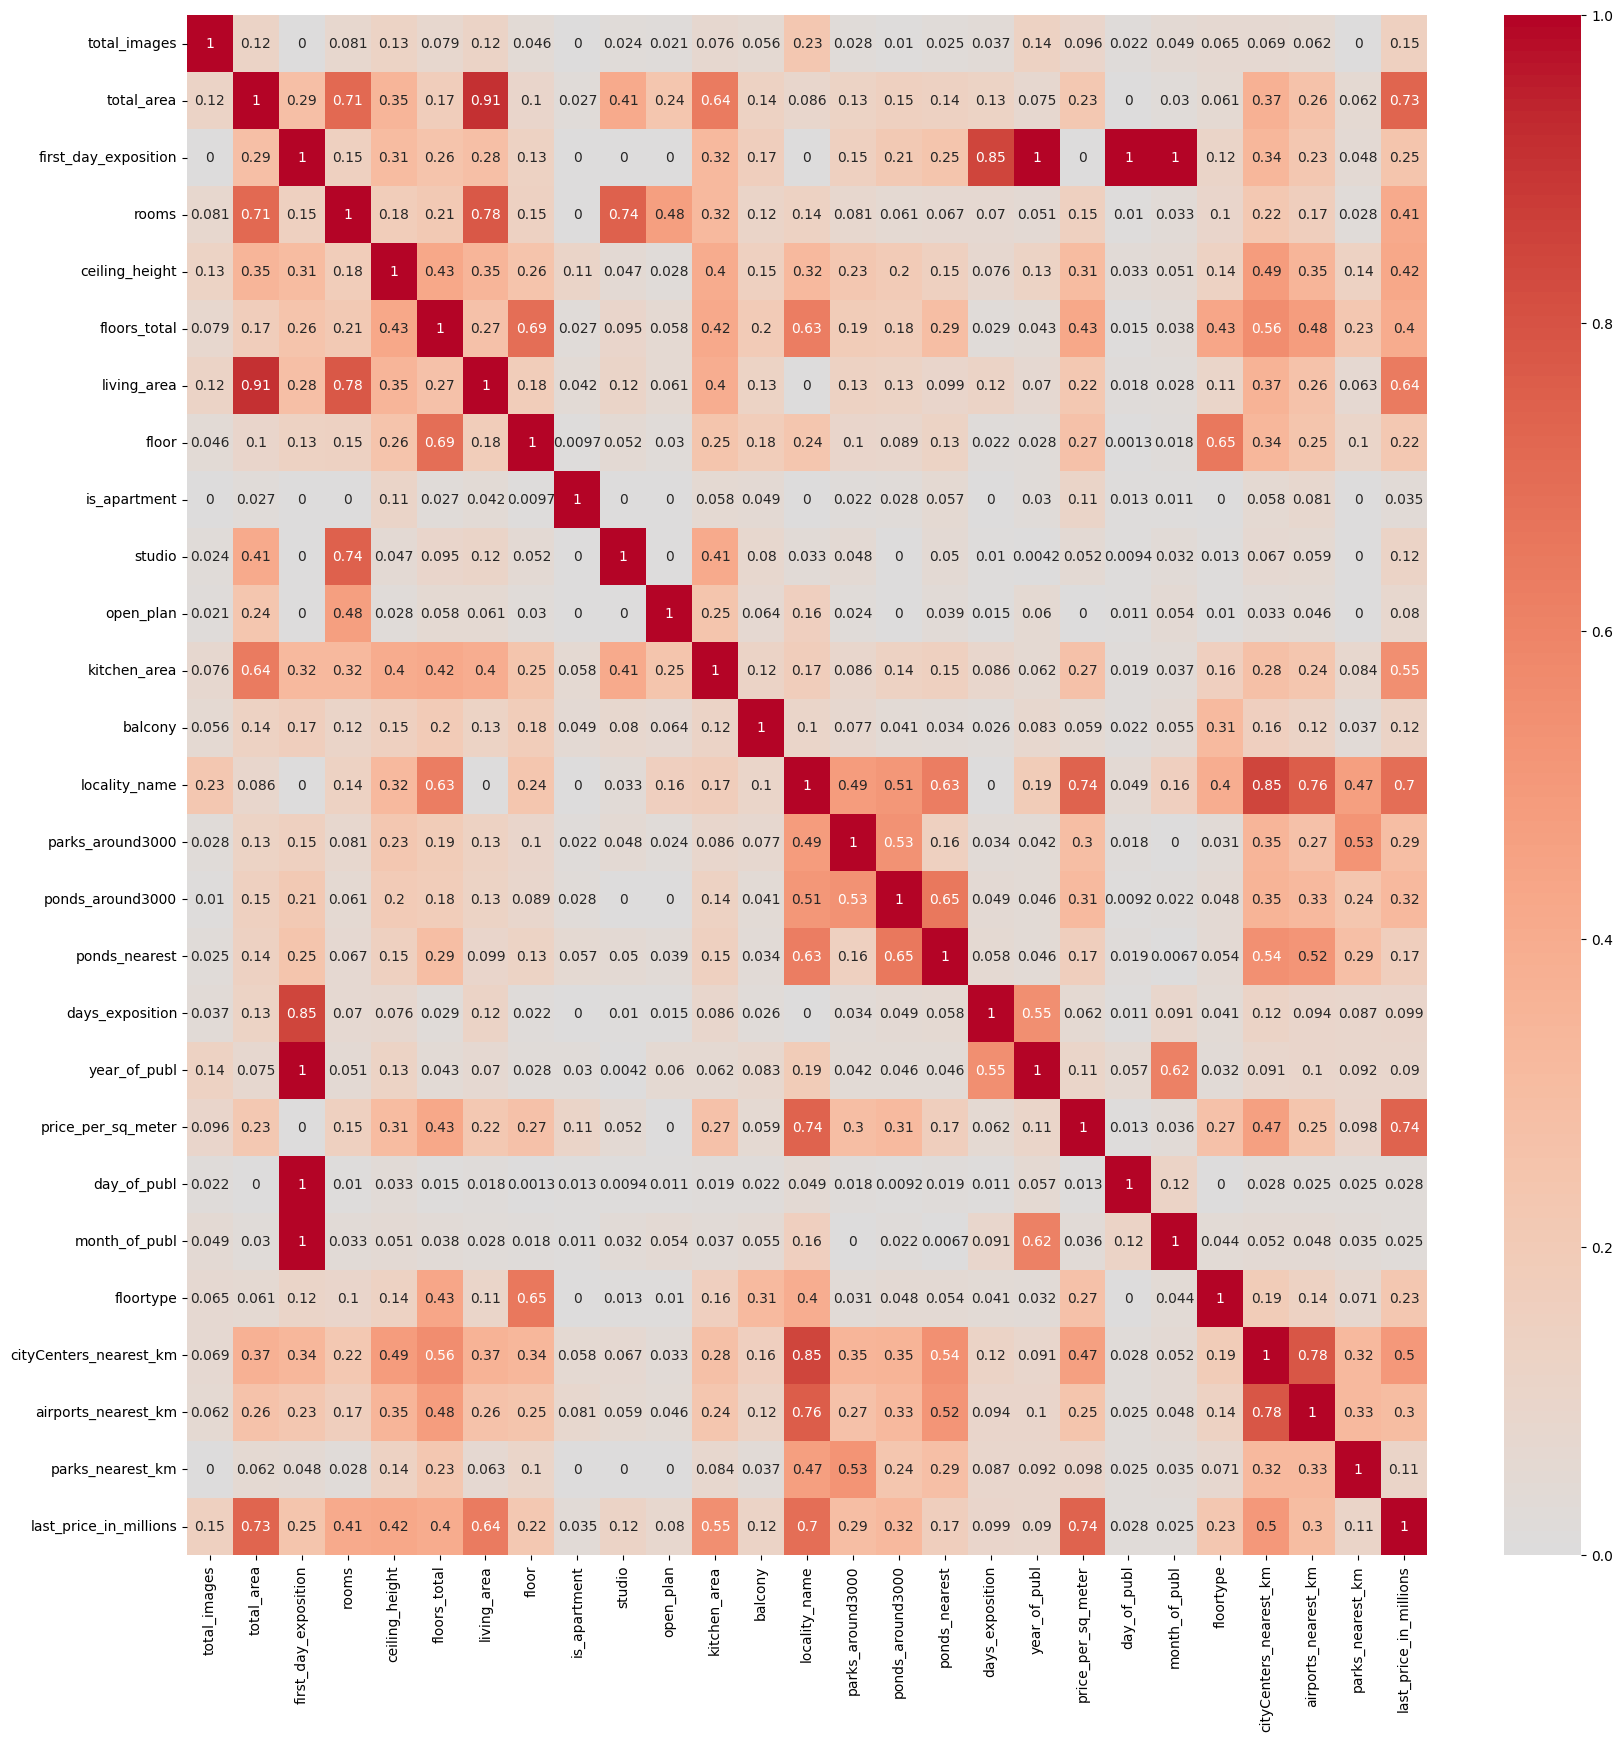

In [83]:
phik_overview = new_data.phik_matrix(interval_cols=interval_cols) 
plt.figure(figsize=(20, 20))
sns.heatmap(phik_overview, cmap='coolwarm', center=0, annot=True) 
phik_overview['last_price_in_millions'].sort_values(ascending=False)

**Вывод:** 
- Больше всего на стоимость влияет общая площадь, что подтверждается банальной логикой, графиками и к. корреляции в 0.73, что отражает высокую степень связи. Аналогично с ценой коррелируют другие показатели площади - жилая и кухни, но они в свою очередь зависят от площади в целом, поэтому учитывать их не следует, общей площади будет достаточно.
- Имеется зависимость на грани сильной между ценой и местностью, что тоже подтверждается логикой: цены в СПБ будут очевидно выше, чем в деревне в области. 
- Есть средняя связь на грани слабой между ценой и расстоянием до центра города.
- Имеется группа показателей со слабой связью с ценой, сюда входит высота потолков, количество комнат, этажность дома, количество прудом в радиусе 3 км, а также расстояние до ближайшего аэропорта. Остальные показатели демонстрируют связь с ценой либо очень слабую, либо на грани погрешности.  
- Первый и последний этаж ценятся ниже промежуточных, особенно первый. 
- По дням публикаций - больше всего цена обычно в рабочие дни, а именно во вторник, меньше всего в субботу. 
- По месяцам публикации - есть резкая просадка в июне и пик в сентябре. 
- По годам публикаций - резкий спал после 2014 года вплоть до 2018, некоторый рост с 2018 по 2019.

### Определение стоимости квадратного метра в десяти населенных пунктах с наибольшим предложением

In [84]:
needed_list = new_data.groupby('locality_name').count()['last_price_in_millions'].sort_values(ascending=False)
needed_list = list(needed_list.index)
needed_list = needed_list[0:10] 

price_per_m = []
locality_names = []

for name, group_data in new_data.groupby('locality_name'):
    if name in needed_list:
        price_per_m.append(group_data['price_per_sq_meter'].mean())
        locality_names.append(name)

d = {'price_per_m': price_per_m}
df = pd.DataFrame(data = d, index=locality_names) 
df = df.sort_values(by='price_per_m', ascending=False)
df.head(10)

,price_per_m
Санкт-Петербург,106806.356789
Пушкин,100890.646045
деревня Кудрово,92611.411183
поселок Парголово,89274.539363
поселок Мурино,85551.941452
поселок Шушары,78473.170798
Колпино,75370.222464
Гатчина,68809.440770
Всеволожск,67268.369444
Выборг,58190.292072


Неудивительно, что первым оказался Санкт-Петербург с ценой порядка 107 тыс. рублей за квадрат, последний - Выборг со стоимостью квадрата около 58 тыс рублей.

### Определение средней цены километра в Санкт-Петербурге

In [85]:
spb_data = new_data.query('locality_name == "Санкт-Петербург"').reset_index() 
spb_table = spb_data.pivot_table(index='cityCenters_nearest_km', values='last_price_in_millions') 
spb_table.head(11)

,last_price_in_millions
cityCenters_nearest_km,
0,8.957000
1,9.044209
2,8.423752
3,8.121022
4,8.547112
5,7.932688
6,7.473802
7,7.234263
8,6.773928


Картина получилась интересная, зависимость есть, но первые четыре километра цена практически не падает, в вот дальше спад более заметен.

## Общий вывод


**Срок продажи квартиры:**

- 25% людей продают квартиру за 45 дней, половина - за 95 дней, 75% - за 200. Продажи быстрее 45 дней можно назвать быстрыми, дольше 400 - долгими.
- Есть варианты квартир, которые продавались несколько десятков месяцев.

**Факторы, влияющие на стоимость:**

- На стоимость больше влияет общая площадь квартиры, с ней сильно коррелируют другие виды площади (жилая и кухни), а также количество комнат, поэтому из всех этих факторов необходимо и достаточно учитывать только общую площадь, чтобы избежать мультиколлинераности. 
- Связь между ценой и географическим центром СПБ есть, но достаточно слабая и проявляется с удалением от центра на 4-5 километров. 
- Присутствует слабая положительная связь цены и высотой потолков, количеством комнат, этажностью дома, количеством прудом в радиусе 3 км, а также расстоянием до ближайшего аэропортаи. 
- Первый и последний этаж ценятся меньше промежуточных. 
- По датам публикаций, больше всего цена обычно в рабочие дни, а именно во вторник, меньше всего в субботу; есть резкая просадка цены в июле и пик в сентябре.
- После 2014 года имел место резкий спад цен вплоть до 2018, затем некоторый рост с 2018 по 2020. 

**Стоимость квадратного метра в населенных пунктах с наибольшим предложением:**
- Дороже всего квадратный метр в Санкт-Петербурге - порядка 107 тыс. рублей
- Дешевле всего квадратный метр в Выборге - около 58 тыс. рублей
